<a href="https://colab.research.google.com/github/akiabe/coursera-dl-tf-in-practice/blob/master/C4W4_Sunspots_kaggle_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

In [0]:
# Define helper function of plotting chart
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [33]:
# Access server and download dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-06-13 19:33:03--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.128, 2404:6800:4003:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-06-13 19:33:03 (92.5 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [0]:
# Read the csv file and get data into a list of sunspots and timesteps
import csv

time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  # Read the column title and end up throwing it away
  next(reader)
  # Loop through the reader and append data into list
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))
  
  # Convert list into numpy array
  series = np.array(sunspots)
  time = np.array(time_step)

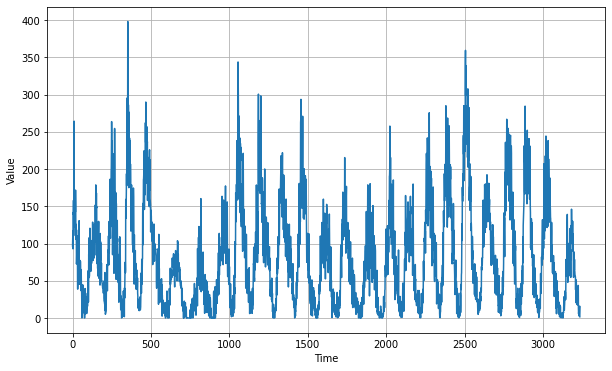

In [35]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
# Split dataset into training and validation sets
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Set the constans that pass to the windowed_dataset function
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
# Define helper function of turning the data into a window dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # Expand 1 dimentional data to Conv1D input data shape
  series = tf.expand_dims(series, axis=1)
  # Create dataset from series and pass the series to it
  dataset = tf.data.Dataset.from_tensor_slices(series)
  # Window the dataset
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  # Mapping a dataset element to a (window_size + 1) batch size dataset
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  # Shuffle the dataset at the shuffle_buffer and split into features and labels
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  # Batch the select batch size
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [0]:
# Define forecasting function
def model_forecast(model, series, window_size):
    # Create a datasets whose elements are slice of series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Window the dataset
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    # Mapping a dataset element to a (window_size) batch size dataset
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    # Batch the select batch size
    dataset = dataset.batch(32).prefetch(1)
    # Generate output predictions for the dataset
    forecast = model.predict(dataset)
    
    return forecast

In [41]:
# Clear any internal variables to make easy to experiment w/o models impacting later versions of themselves.
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Set the dataset
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

# Buld the convolutional and LSTM-based model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Set the learning rate by callbacks
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(
    train_set,
    epochs=100,
    verbose=1,
    callbacks=[lr_schedule]
)

print("Training Complete!")

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 0s 29ms/step - loss: 81.4328 - mae: 81.9305 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 0s 25ms/step - loss: 80.2591 - mae: 80.7567 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 0s 25ms/step - loss: 78.5311 - mae: 79.0287 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 0s 24ms/step - loss: 76.5364 - mae: 77.0339 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 0s 27ms/step - loss: 74.4509 - mae: 74.9484 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 0s 25ms/step - loss: 72.3866 - mae: 72.8840 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 27ms/step - loss: 70.4372 - mae: 70.9347 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 0s 28ms/step - loss: 68.6067 - mae: 69.1043 - lr: 2.2

(1e-08, 0.0001, 0.0, 60.0)

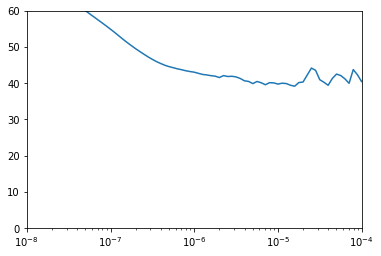

In [42]:
# Plot the loss and check the stable point of learning point
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

# Stable point -- 1e-5

In [43]:
# Retrain the same model with stable learning point

# Clear any internal variables to make easy to experiment w/o models impacting later versions of themselves.
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Set the dataset
window_size = 60
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

# Buld the convolutional and LSTM-based model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(
    train_set,
    epochs=500,
    verbose=1
)

print("Training Complete!")

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/500
30/30 [==============================] - 0s 14ms/step - loss: 51.2724 - mae: 51.7703
Epoch 2/500
30/30 [==============================] - 0s 13ms/step - loss: 41.6318 - mae: 42.1290
Epoch 3/500
30/30 [==============================] - 0s 14ms/step - loss: 40.7383 - mae: 41.2356
Epoch 4/500
30/30 [==============================] - 0s 14ms/step - loss: 40.4475 - mae: 40.9446
Epoch 5/500
30/30 [==============================] - 0s 14ms/step - loss: 39.9421 - mae: 40.4393
Epoch 6/500
30/30 [==============================] - 0s 14ms/step - loss: 40.4063 - mae: 40.9034
Epoch 7/500
30/30 [==============================] - 0s 13ms/step - loss: 40.3627 - mae: 40.8599
Epoch 8/500
30/30 [==============================] - 0s 13ms/step - loss: 39.5303 - mae: 40.0276
Epoch 9/500
30/30 [==============================] - 0s 15ms/step - loss: 38.5223 - mae: 39.0193
Epoch 10/500
30/30 [===========

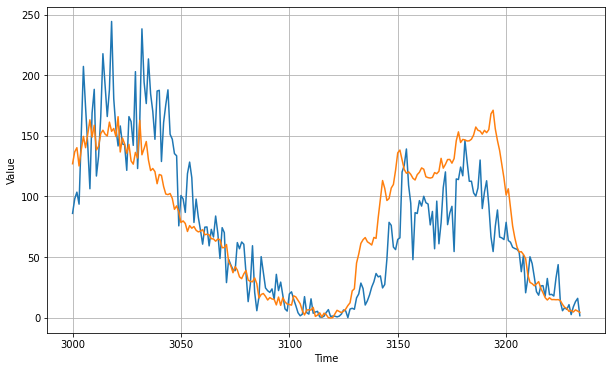

In [44]:
# Forecast every time points of time series
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)

# Split results after split time
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

# Plot results
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# Actual -- Blue, Prediction -- Orange

In [45]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.6749

<Figure size 432x288 with 0 Axes>

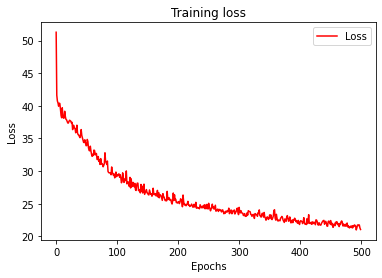

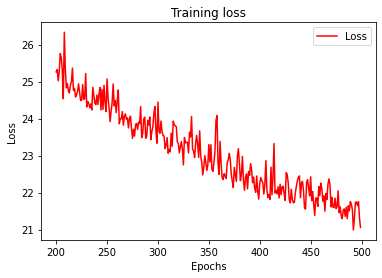

<Figure size 432x288 with 0 Axes>

In [46]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [47]:
print(rnn_forecast)

[ 1.26941910e+02  1.36808319e+02  1.40174179e+02  1.25100067e+02
  1.38326126e+02  1.49514236e+02  1.40185944e+02  1.51308792e+02
  1.63154556e+02  1.48888062e+02  1.58716385e+02  1.38292175e+02
  1.41317230e+02  1.51838104e+02  1.54591293e+02  1.51396591e+02
  1.49797195e+02  1.61261551e+02  1.53685440e+02  1.56016403e+02
  1.49344177e+02  1.65735977e+02  1.36628815e+02  1.48168793e+02
  1.43436340e+02  1.35559387e+02  1.42903214e+02  1.29256165e+02
  1.26587936e+02  1.36282288e+02  1.31682724e+02  1.62822571e+02
  1.34336624e+02  1.39499954e+02  1.45270569e+02  1.30093903e+02
  1.21270645e+02  1.22999657e+02  1.20423508e+02  1.10464767e+02
  1.18070984e+02  1.17363945e+02  1.08153809e+02  1.01947701e+02
  1.01476517e+02  1.02381599e+02  9.83684158e+01  8.93270340e+01
  9.21632996e+01  8.73783264e+01  7.84260178e+01  7.97636337e+01
  7.76706238e+01  7.10641861e+01  7.58896255e+01  7.37611084e+01
  7.51535110e+01  7.20095901e+01  7.07169113e+01  7.13059006e+01
  7.25967560e+01  6.83769